# Mammography segmentation solutions with Machine Learning

## Dataset

### EMBED
EMmory brEast Imagin Dataset (EMBED): https://registry.opendata.aws/emory-breast-imaging-dataset-embed/


## Breast Calcification

Throughout discription:
https://www.breastcancer.org/screening-testing/mammograms/calcifications

### Defining variables that are used in every part of the code

In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = '/home/szelesteya/projects/EMBED_Open_Data/'
tables_path = data_path + 'tables/'
image_root_path = '/media/szelesteya/F824D4D024D492CC/EMBED-images/'
image_dest_path = image_root_path + 'all-calc-with-roi-reduced'
image_figure_path = image_root_path + 'extract'
image_negative_path = image_root_path + 'negative'
image_resized_path = image_root_path + 'resized'

### Examine labels and pulling down the neccessary images

Only run these lines once, because it may take long time

#### Type of calcification labels

In [3]:
legends = pd.read_csv(tables_path + 'AWS_Open_Data_Clinical_Legend.csv')

calc_findings_codes = (legends[legends['Header in export'].str.contains('calcfind')])[['Meaning','Code']].values
calc_distrib_codes = (legends[legends['Header in export'].str.contains('calcdistri')])[['Meaning','Code']].values

## Possible calcification findings and it's codes
print(calc_findings_codes)

## Possible calcification distribution types and it's codes
print(calc_distrib_codes)

[['Amorphous' 'A']
 ['Benign' '9']
 ['Coarse heterogeneous' 'H']
 ['Course Popcorn-like' 'C']
 ['Dystrophic' 'D']
 ['Rim' 'E']
 ['Fine-linear (casting)' 'F']
 ['Fine linear-branching (casting)' 'B']
 ['Generic' 'G']
 ['Fine pleomorphic' 'I']
 ['Large Rodlike' 'L']
 ['Milk of calcium' 'M']
 ['Oil Cyst' 'J']
 ['Pleomorphic' 'K']
 ['Punctate' 'P']
 ['Round' 'R']
 ['Skin' 'S']
 ['Lucent-centered' 'O']
 ['Suture' 'U']
 ['Vascular' 'V']
 ['Coarse' 'Q']]
[['Grouped' 'G']
 ['Segmental' 'S']
 ['Regional' 'R']
 ['Diffuse/scattered' 'D']
 ['Linear' 'L']
 ['Clustered' 'C']]


#### Find the calcification findings in the clinical data table

In [266]:
data = pd.read_csv(tables_path + 'EMBED_OpenData_clinical.csv', low_memory=False)

calc_findings = (data[((data['calcfind'].notna() | data['calcdistri'].notna())) & data['path_severity'].notna()])[['Unnamed: 0','empi_anon','acc_anon','side','calcfind','calcdistri','otherfind','numfind','path_severity','age_at_study', 'ETHNICITY_DESC']]

#### Find the pictures containing ROI information and no special view then merge it with the calcification findings

In [5]:
metadata = (pd.read_csv(tables_path + 'EMBED_OpenData_metadata_reduced.csv', low_memory=False))

metadata_with_ROI = metadata[(metadata['ROI_coords'].str.contains('\d', regex=True) & (metadata['spot_mag'] != 1.0))]

calc_findings = calc_findings.rename(columns={'side':'ImageLateralityFinal'})
calc_findings = pd.merge(calc_findings, metadata_with_ROI, on=['empi_anon','acc_anon','ImageLateralityFinal'])

calc_findings = calc_findings[['empi_anon','acc_anon','anon_dicom_path','ImageLateralityFinal','ROI_coords','calcfind','calcdistri','path_severity','spot_mag','age_at_study', 'ETHNICITY_DESC']].copy()

calc_findings.loc[:, 'relative_dcm_path'] = calc_findings['anon_dicom_path'].copy()
calc_findings.loc[:, 'relative_dcm_path'] = calc_findings['relative_dcm_path'].str.split('/')
calc_findings.loc[:, 'relative_dcm_path'] = calc_findings['relative_dcm_path'].apply(lambda x: '/'.join(x[7:]))

with open(data_path + 'calc_findings_full.csv', 'w') as f:
    (calc_findings).to_csv(f, index=False)

with open(data_path + 'calc_findings_path.csv', 'w') as f:
    (calc_findings['relative_dcm_path']).to_csv(f, index=False)

print(calc_findings)

      empi_anon          acc_anon  \
0      83470524  6673752246827871   
1      83470524  6673752246827871   
2      78265628  4449047670783206   
3      78265628  4449047670783206   
4      94908279  8999508623837278   
...         ...               ...   
1955   41216370  9987717412533391   
1956   41216370  9987717412533391   
1957   41216370  9987717412533391   
1958   93869302  5208318985884426   
1959   93869302  5208318985884426   

                                        anon_dicom_path ImageLateralityFinal  \
0     /mnt/NAS2/mammo/anon_dicom/cohort_1/83470524/1...                    L   
1     /mnt/NAS2/mammo/anon_dicom/cohort_1/83470524/1...                    L   
2     /mnt/NAS2/mammo/anon_dicom/cohort_1/78265628/1...                    R   
3     /mnt/NAS2/mammo/anon_dicom/cohort_1/78265628/1...                    R   
4     /mnt/NAS2/mammo/anon_dicom/cohort_1/94908279/1...                    R   
...                                                 ...                  ..

#### Pulling the images using aws

In [10]:
%%bash -s "$image_dest_path" "{data_path}calc_findings_path.csv"

dcm_dest_path="$1"
dcm_paths="$2"

tail -n +2 $dcm_paths | while IFS= read -r line; do
    relative_path=$(echo "$line" | awk -v OFS='/' '{$1=$1; print}')
    dcm_name=$(echo "$relative_path" | cut -d '/' -f 3-)

    echo "s3://embed-dataset-open/images/$relative_path"
    # aws s3 cp "s3://embed-dataset-open/images/$relative_path" "${dcm_dest_path}/$dcm_name" --profile my-dev-profile
done

s3://embed-dataset-open/images/1.2.845.113975.3.59.1.50221084.20141110.1112012/1.2.840.113683.2750851774.1415170262.5404.2675/1.2.826.0.1.3680043.8.498.12681424261940133202438074551382227544.dcm
s3://embed-dataset-open/images/1.2.845.113975.3.59.1.50221084.20141110.1112012/1.2.842.113688.2750851775.1415170261.5405.2695/1.2.826.0.1.3680043.8.498.39167993503878102186225771580782440618.dcm
s3://embed-dataset-open/images/1.2.846.113971.3.66.1.51529504.20150736.1115118/1.2.840.113683.2750824974.1438237380.2336.34556/1.2.826.0.1.3680043.8.498.10735466440989741668586797439596379519.dcm
s3://embed-dataset-open/images/1.2.846.113971.3.66.1.51529504.20150736.1115118/1.2.842.113685.2750824975.1438237385.2336.34566/1.2.826.0.1.3680043.8.498.11876851440454397415965504044496659551.dcm
s3://embed-dataset-open/images/1.2.849.113979.3.66.1.51120217.20150510.1092161/1.2.840.113688.2229460970.1091.3608451148.121.1/1.2.826.0.1.3680043.8.498.79958064610726146381197861159911560926.dcm
s3://embed-dataset-ope

#### Convert dcm to png (with the code of the EMBED repository)

In [3]:
import pydicom
import numpy as np
import pandas as pd
import png
import math
from PIL import Image
from pathlib import Path

In [4]:
# Variables
image_path = image_dest_path + '-png/'

In [5]:
# Get DICOM image metadata
class DCM_Tags():
    def __init__(self, img_dcm):
        try:
            self.laterality = img_dcm.ImageLaterality
        except AttributeError:
            self.laterality = np.nan
            
        try:
            self.view = img_dcm.ViewPosition
        except AttributeError:
            self.view = np.nan
            
        try:
            self.orientation = img_dcm.PatientOrientation
        except AttributeError:
            self.orientation = np.nan

# Check whether DICOM should be flipped
def check_dcm(imgdcm):
    # Get DICOM metadata
    tags = DCM_Tags(imgdcm)
    
    # If image orientation tag is defined
    if ~pd.isnull(tags.orientation):
        # CC view
        if tags.view == 'CC':
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False
            
            if (tags.laterality == 'L') & (tags.orientation[1] == 'L'):
                flipVert = True
            elif (tags.laterality == 'R') & (tags.orientation[1] == 'R'):
                flipVert = True
            else:
                flipVert = False
        
        # MLO or ML views
        elif (tags.view == 'MLO') | (tags.view == 'ML'):
            if tags.orientation[0] == 'P':
                flipHorz = True
            else:
                flipHorz = False
            
            if (tags.laterality == 'L') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HL')):
                flipVert = True
            elif (tags.laterality == 'R') & ((tags.orientation[1] == 'H') | (tags.orientation[1] == 'HR')):
                flipVert = True
            else:
                flipVert = False
        
        # Unrecognized view
        else:
            flipHorz = False
            flipVert = False
            
    # If image orientation tag is undefined
    else:
        # Flip RCC, RML, and RMLO images
        if (tags.laterality == 'R') & ((tags.view == 'CC') | (tags.view == 'ML') | (tags.view == 'MLO')):
            flipHorz = True
            flipVert = False
        else:
            flipHorz = False
            flipVert = False
            
    return flipHorz, flipVert

# Rescale the intensity of the image to get heterogene images with the bit depth of 14
def rescale_to_14bit(image_array):
    upper_percentile = np.percentile(image_array.flatten(), 98) # original_max = np.max(image_array)
    lower_percentile = np.percentile(image_array.flatten(), 2) # original_min = np.min(image_array)
    # max_on_14bit = 16383
    max = 255
    rescaled_array = (image_array - lower_percentile) / (upper_percentile - lower_percentile)
    rescaled_array[rescaled_array < 0] = 0
    rescaled_array[rescaled_array > 1] = 1
    # rescaled_array = np.round((image_array - original_min) / (original_max - original_min) * max_on_14bit).astype(int)
    return np.round(rescaled_array * 255).astype(np.uint8)

# Save DICOM pixel array as PNG
def save_dcm_image_as_png(image, png_filename, bitdepth=8):
    with open(png_filename, 'wb') as f:
        rescaled = rescale_to_14bit(image)
        writer = png.Writer(height=rescaled.shape[0], 
                            width=rescaled.shape[1], 
                            bitdepth=bitdepth, 
                            greyscale=True)
        writer.write(f, rescaled.tolist())

In [6]:
def generate_png_path(dcm_path):
    # Get new file name
    split_fn = dcm_path[:-4].split('/')
    new_fn = f"{split_fn[-1]}_conv.png"
    return image_path + new_fn

In [7]:
# Convert list of DICOMs to PNGs
def process_dcm_list(findings_df):
    dcm_list = findings_df['full_dcm_path']
    png_list = findings_df['full_png_path']
    
    for i, dcm_path in enumerate(dcm_list):    
        if not Path(png_list[i]).exists():
            print(f"Processing DICOM #{i}...")
            
            # Load DICOM
            dcm = pydicom.dcmread(dcm_path)
            img = dcm.pixel_array
            
            # Check if a horizontal flip is necessary
            horz, _ = check_dcm(dcm)
            if horz:
                # Flip img horizontally
                img = np.fliplr(img)
            
            # Save PNG            
            save_dcm_image_as_png(img, png_list[i])

In [8]:
def extract_images(data_file_name, destination_library):
    # Provide a list of DICOM paths and a target directory
    dcm_list = []
    df_path = f'{data_path}{data_file_name}.csv'
    df = pd.read_csv(df_path)
    
    for index, row in df.iterrows():
        path = destination_library  + '/' + row['relative_dcm_path']
        if Path(path).exists():
            dcm_list.append(path)
    
    # Insert dicom path
    df.loc[:,'full_dcm_path'] = dcm_list
        
    # Insert png path
    df.loc[:,'full_png_path'] = df['full_dcm_path'].copy()
    df.loc[:,'full_png_path'] = df['full_png_path'].apply( lambda x: generate_png_path(x))
    
    with open(df_path, 'w') as f:
        (df).to_csv(f, index=False)
    
    # Convert DICOMs
    process_dcm_list(df)

    return df

In [80]:
calc_findings = extract_images('calc_findings_full', image_dest_path)

0       /media/szelesteya/F824D4D024D492CC/EMBED-image...
1       /media/szelesteya/F824D4D024D492CC/EMBED-image...
2       /media/szelesteya/F824D4D024D492CC/EMBED-image...
3       /media/szelesteya/F824D4D024D492CC/EMBED-image...
4       /media/szelesteya/F824D4D024D492CC/EMBED-image...
                              ...                        
1955    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1956    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1957    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1958    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1959    /media/szelesteya/F824D4D024D492CC/EMBED-image...
Name: full_dcm_path, Length: 1960, dtype: object


### Examine pictures' intensity and the quality of the ROI 

In [9]:
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

import math
from PIL import Image

#### Make histogram of the intensities of the pictures

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

In [11]:
def calculate_intensity(pixel_array):
    # Drop the part not containing tissues
    pixel_array = np.array(pixel_array)
    pixel_array = pixel_array[pixel_array > 1.5]
    intensity = np.mean(pixel_array)
    return intensity

In [12]:
def calculate_intensity_of_png(calc_findings):
    intensities_array = []
    png_list = calc_findings['full_png_path'].tolist()
    
    print(f'Calculating intensitiy for {len(png_list)} png image')
    for index in range(len(png_list)):
        print(f'{index + 1} / {len(png_list)}\nCalculating intensity for image {png_list[index]}\n...')
        # Get pixel array from dicom path
        image = Image.open(png_list[index])

        pixel_array = np.array(image)
        intensity = calculate_intensity(pixel_array)

        print(f'Intensity is {intensity}\n')
        intensities_array.append(intensity)        

    return intensities_array

Only calculate intensity for each picture if our datatable don't contain it already, because this may take time

Calculating intensitiy for 1960 png image
1 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.12681424261940133202438074551382227544_conv.png
...
Intensity is 139.21326802085548

2 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.39167993503878102186225771580782440618_conv.png
...
Intensity is 115.15220944953283

3 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.10735466440989741668586797439596379519_conv.png
...
Intensity is 146.9876777232628

4 / 1960
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.11876851440454397415965504044496659551_conv.png
...
Intensity is 131.68201836007535

5 / 1960
Calculating intensity for imag

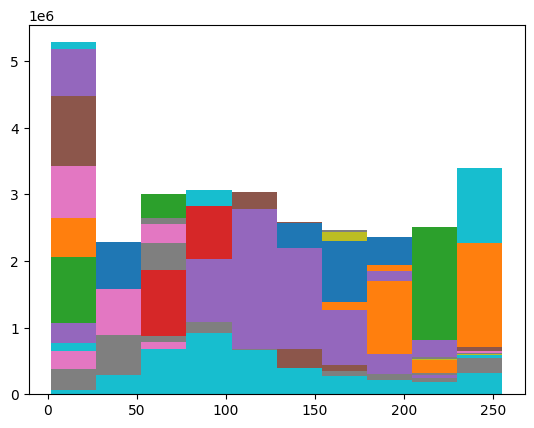

In [84]:
## Calculate intensities for each image and append it to the DataFrame this may take a while
intensities_array = None
intensities_array = calculate_intensity_of_png(calc_findings)

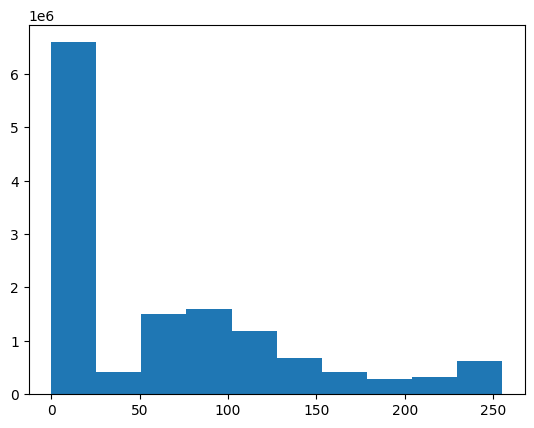

118.31686751093704

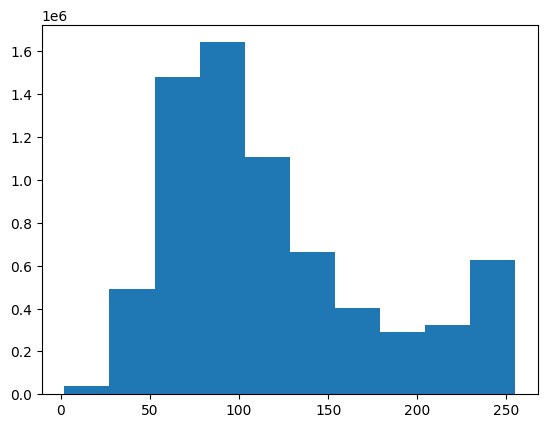

In [55]:
image = Image.open('/media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.10084868060616841395708036269303740957_conv.png')
plt.hist(np.array(image).flatten())
plt.show()
calculate_intensity(image)

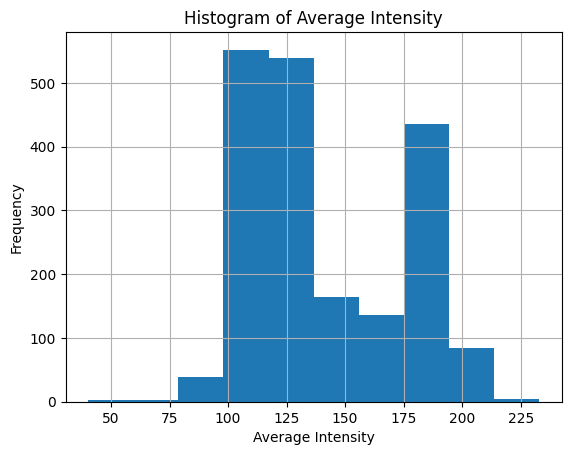

In [56]:
#intensities_cut_array = intensities_array[~(intensities_array > 1000)]
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

if intensities_array is None:
    intensities_array = calc_findings['intensity'].tolist()

hist, bins = np.histogram(intensities_array)
plt.stairs(hist, bins, fill='True')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Intensity')
plt.grid(True)
plt.savefig('avg_intensity_histogram.png')

In [85]:
# Insert intensities in the DataFrame and save the histogram
calc_findings.loc[:,'intensity'] = intensities_array
min_intensity = bins[np.where(hist == np.max(hist))]
calc_findings = calc_findings[calc_findings['intensity'] > min_intensity[0]]

with open(data_path + 'calc_findings_full.csv', 'w') as f:
    (calc_findings).to_csv(f, index=False)

NameError: name 'bins' is not defined

#### Classifying the calcifications and showcase ROI with minimalistic GUI

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image

calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

In [19]:
def parse_ROI(roi_coords_row):
    roi_coords_array = roi_coords_row[2:-1].split('(')
    roi_rects = []
    
    for i in range(len(roi_coords_array)):
        roi_coords_str = roi_coords_array[i].split(')')[0].replace(" ","").split(',')
        if "" not in roi_coords_str:
            try:
                roi_coords = [eval(j.replace('[', '').replace(']','')) for j in roi_coords_str]
    
                x_min = roi_coords[1]
                y_min = roi_coords[0]
                x_max = roi_coords[3]
                y_max = roi_coords[2]
                
                roi_rects.append([x_min, y_min, x_max, y_max])
            except SyntaxError:
                print(roi_coords_str)

    return roi_rects

In [25]:
def showcase_ROI(calcfinding_row, save):
    image = Image.open(calcfinding_row['full_png_path'])
    image_array = np.array(image)
        
    path = (image_figure_path + '/' + '.'.join(calcfinding_row['relative_dcm_path'].split('/')))[:-4]
    # path = calcfinding_row['resized_path']
    
    only_ROI_arrays = []
    
    # Coordinate(s) of any detected ROI on the image, represented as a list of lists. 
    # Sublists contains corner coordinates for ROI in the format ‘ymin, xmin, ymax, xmax’.
    roi_coords_array = parse_ROI(calcfinding_row['ROI_coords'])

    aspect_ratio = image_array.shape[1] / image_array.shape[0]
    fig_all, axis_all = plt.subplots(figsize=(4*aspect_ratio, 4))
    axis_all.imshow(image_array, cmap='gray')
    
    for roi in roi_coords_array:
        x_min = roi[0]
        x_max = roi[2]
        y_min = roi[1]
        y_max = roi[3]
        rectangle = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        axis_all.add_patch(rectangle)
        
        only_ROI_arrays.append(image_array[y_min:y_max, x_min:x_max])

    axis_all.set_aspect('equal', adjustable='datalim')
    plt.axis('off')
    if save:
        plt.savefig(path + '_all.png', bbox_inches='tight', pad_inches=0, dpi=300)
    else:
        plt.imshow(image_array, cmap='gray')

    fig, axs = plt.subplots(1, len(only_ROI_arrays), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.1)
    for i in range(len(roi_coords_array)):
        if len(roi_coords_array) > 1:
            axs[i].axis('off')
            axs[i].imshow(only_ROI_arrays[i], cmap='gray')
        else:
            axs.axis('off')
            axs.imshow(only_ROI_arrays[i], cmap='gray')
        
    if save:
        fig.savefig(path + '_rois.png',  bbox_inches='tight', pad_inches=0, dpi=300)

I used a GUI to find images for my purposes more efficiently

In [26]:
import ipywidgets as widgets
from IPython.display import display

In [27]:
value = 0

In [28]:
def on_value_change(num):
    global value
    value = num
    showcase_ROI(calc_findings.loc[value,:], False)        
    print(calc_findings.loc[value,:])

def save_figure(b):
    global value
    with button_output:
        showcase_ROI(calc_findings.loc[value,:], True)

In [29]:
# Create a slider for input
number_slider = widgets.IntSlider(value=1122, min=1, max=1959, description='Number:')

button_save = widgets.Button(description="Save figures")
button_save.on_click(save_figure)

button_output = widgets.Output()

# Create an interactive output that updates when the slider value changes
slider_output = widgets.interactive_output(on_value_change, {'num': number_slider})

# Display the slider and the output
display(number_slider, slider_output)
display(button_save, button_output)

IntSlider(value=1122, description='Number:', max=1959, min=1)

Output()

Button(description='Save figures', style=ButtonStyle())

Output()

### Histogram Equalizations

https://pyimagesearch.com/2021/02/01/opencv-histogram-equalization-and-adaptive-histogram-equalization-clahe/

In [19]:
import cv2 as cv
import os
import imageio.v3 as iio

equalized_img_path = image_dest_path + '-equalized'
clahe_img_path = image_dest_path + '-clahe'
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

#### Histrogram Equalization

In [20]:
def hist_eq(image_source, image_destination):
    img = cv.imread(image_source, cv.IMREAD_GRAYSCALE)
    equ = cv.equalizeHist(img)
    res = np.array(equ)
    cv.imwrite(image_destination, res)

In [21]:
def calculate_intensity_for_png(image_path):
    pixel_array = iio.imread(image_path)
    return calculate_intensity(pixel_array)

In [41]:
calc_findings['equalized_img_path'] = calc_findings['full_png_path']
calc_findings['intensity_after_eq'] = calc_findings['intensity']
intensity_array = []

for i in range(len(calc_findings.loc[::10, 'full_png_path'])):
    dest = equalized_img_path + f'/{i*10}.jpg'
    hist_eq(calc_findings.loc[i*10,'full_png_path'], dest)
    calc_findings.loc[i*10,'equalized_img_path'] = dest
    calc_findings.loc[i*10,'intensity_after_eq'] = calculate_intensity_for_png(dest)
    intensity_array.append(calc_findings.loc[i*10,'intensity_after_eq'])
    print(calc_findings.loc[i*10,'intensity_after_eq'])

129.2623689023666
128.16589114581495
128.32032086380298
128.8858847888627
129.12892271795556
128.84812916162718
128.4252327847184
139.16951244994584
130.03001087262564
128.69197078405983
128.5035430499286
128.5156220981639
129.94870653276934
128.26517281326244
129.3473512057995
129.4455456600674
128.9064503937776
128.67814845019433
128.40631016424553
128.14547119413118
128.73764636902231
128.29492938408964
128.0849655426617
128.6459709893809
128.72159506871856
128.4043034432444
129.38621001740148
129.33806469299722
128.21668569635085
128.59131425753694
128.75088266534885
128.444004236579
129.31309645652956
129.51487710128947
128.31835402294507
128.61989841088268
128.82891635905375
128.59821364298227
128.7350037193874
128.707310114464
129.6617785642544
128.88039789890456
130.2432439133143
128.832993085792
128.3575159433071
128.88675369117985
128.21714038797816
128.41097294332218
129.85718328484973
128.61257700001877
129.35161516647204
128.33973596461922
130.37843080944538
128.4944787933

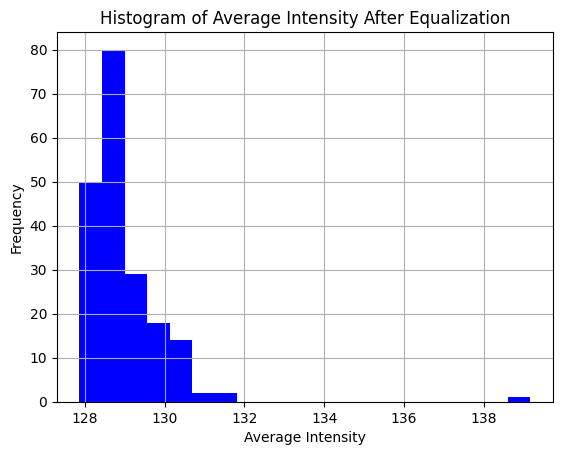

In [42]:
plt.hist(intensity_array, bins=20, color='blue')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Intensity After Equalization')
plt.grid(True)
plt.savefig('avg_intensity_equalized_histogram.png')

#### Adaptive Histogram Equalization (CLAHE)

In [22]:
def clahe_image(image_source, image_destination):
    image = cv.imread(image_source)
    image_grey = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    clahe = cv.createCLAHE(clipLimit=5)
    final_img = clahe.apply(image_grey)
    cv.imwrite(image_destination, final_img)

In [97]:
calc_findings['clahe_img_path'] = calc_findings['full_png_path']
calc_findings['intensity_after_clahe'] = calc_findings['intensity']
intensity_array = []

for i in range(len(calc_findings.loc[:, 'full_png_path'])):
    dest = clahe_img_path + f'/{i}.jpg'
    clahe_image(calc_findings.loc[i,'full_png_path'], dest)
    calc_findings.loc[i,'clahe_img_path'] = dest
    calc_findings.loc[i,'intensity_after_clahe'] = calculate_intensity_of_png(dest)
    intensity_array.append(calc_findings.loc[i,'intensity_after_clahe'])

TypeError: string indices must be integers

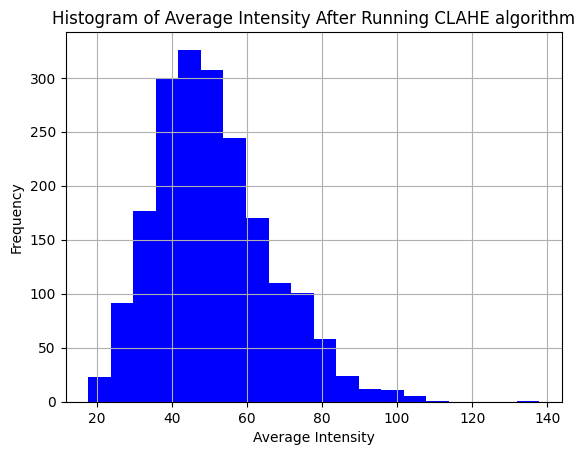

In [45]:
plt.hist(intensity_array, bins=20, color='blue')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Intensity After Running CLAHE algorithm')
plt.grid(True)
plt.savefig('avg_intensity_clahe_histogram.png')

Saving the path of new images and intensities

In [46]:
with open(data_path + 'calc_findings_full.csv', 'w') as f:
    (calc_findings).to_csv(f, index=False)

#### 

### Adding negative result to the dataset

In [34]:
data = pd.read_csv(tables_path + 'EMBED_OpenData_clinical.csv', low_memory=False)

## Around 
negative_data = data[(data['asses'] == 'N') & (~data['path_severity'].notna())][['Unnamed: 0','empi_anon','acc_anon','side','calcfind','calcdistri','otherfind','numfind','path_severity','age_at_study','ETHNICITY_DESC']]
negative_data = negative_data.rename(columns={'side':'ImageLateralityFinal'})

metadata = (pd.read_csv(tables_path + 'EMBED_OpenData_metadata_reduced.csv', low_memory=False))
metadata_reduced = metadata[metadata['spot_mag'] != 1.0][['empi_anon','acc_anon','ImageLateralityFinal','anon_dicom_path']]

negative_data = pd.merge(negative_data, metadata_reduced, on=['empi_anon','acc_anon','ImageLateralityFinal'])

negative_data = negative_data[['empi_anon','acc_anon','anon_dicom_path','ImageLateralityFinal','calcfind','calcdistri','age_at_study', 'ETHNICITY_DESC']].copy()

negative_data.loc[:, 'relative_dcm_path'] = negative_data['anon_dicom_path'].copy()
negative_data.loc[:, 'relative_dcm_path'] = negative_data['relative_dcm_path'].str.split('/')
negative_data.loc[:, 'relative_dcm_path'] = negative_data['relative_dcm_path'].apply(lambda x: '/'.join(x[7:]))

In [ ]:
for i i

#### Examining the Ethnicity and age distribution

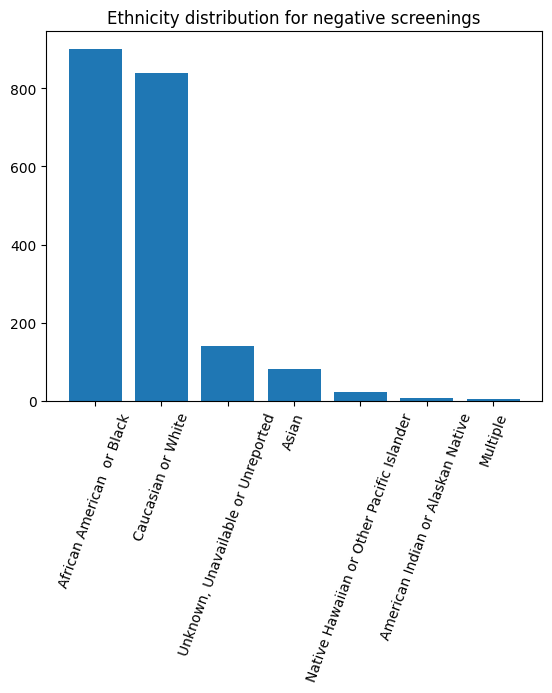

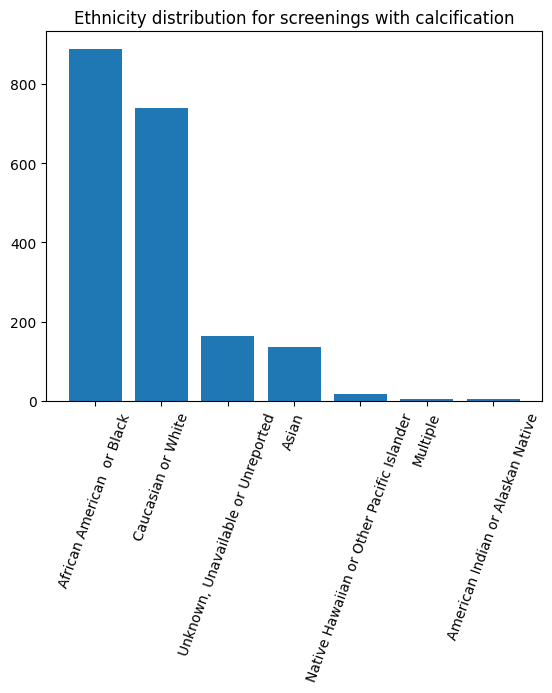

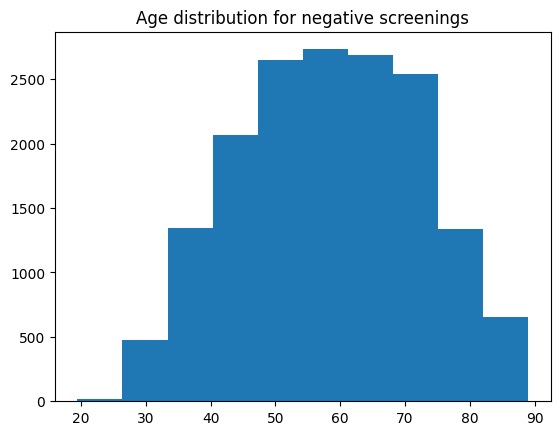

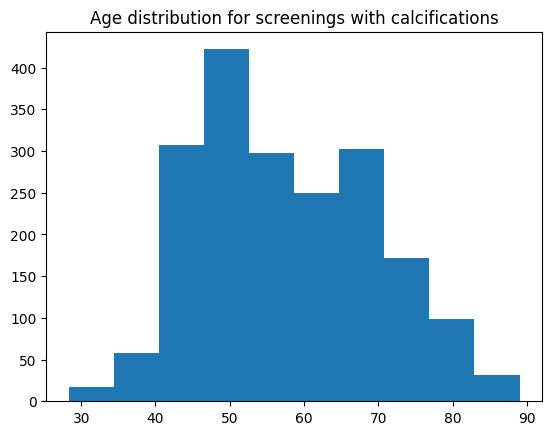

In [25]:
negative_sampled = negative_data.sample(2000)

ethnicity_negative = negative_sampled['ETHNICITY_DESC'].value_counts().reset_index()
ethnicity_negative.columns = ['Ethnicity','Frequency']
ethnicity_positive = calc_findings['ETHNICITY_DESC'].value_counts().reset_index()
ethnicity_positive.columns = ['Ethnicity','Frequency']

plt.bar(ethnicity_negative['Ethnicity'], ethnicity_negative['Frequency'])
plt.title('Ethnicity distribution for negative screenings')
plt.xticks(rotation=70)
plt.show()

plt.bar(ethnicity_positive['Ethnicity'], ethnicity_positive['Frequency'])
plt.title('Ethnicity distribution for screenings with calcification')
plt.xticks(rotation=70)
plt.show()

plt.hist(negative_data['age_at_study'])
plt.title('Age distribution for negative screenings')
plt.show()

plt.hist(calc_findings['age_at_study'])
plt.title('Age distribution for screenings with calcifications')
plt.show()

In [33]:
with open(data_path + 'negative_full.csv', 'w') as f:
    (negative_sampled).to_csv(f, index=False)

with open(data_path + 'negative_path.csv', 'w') as f:
    (negative_sampled['anon_dicom_path']).to_csv(f, index=False)

In [37]:
%%bash -s "$image_negative_path" "{data_path}negative_path.csv"

dcm_dest_path="$1"
dcm_paths="$2"

tail -n +2 $dcm_paths | while IFS= read -r line; do
    relative_path=$(echo "$line" | cut -d '/' -f 6-| awk -v OFS='/' '{$1=$1; print}')
    dcm_name=$(echo "$relative_path" | cut -d '/' -f 3-)

    echo "s3://embed-dataset-open/images/$relative_path"
    aws s3 cp "s3://embed-dataset-open/images/$relative_path" "${dcm_dest_path}/$dcm_name" --profile my-dev-profile
done

s3://embed-dataset-open/images/cohort_1/90494304/1.2.843.113976.3.57.1.48322012.20130918.1125553/1.2.846.113684.2750824665.1379399488.5076.733/1.2.826.0.1.3680043.8.498.84064189930309986389986663501451297790.dcm
download: s3://embed-dataset-open/images/cohort_1/90494304/1.2.843.113976.3.57.1.48322012.20130918.1125553/1.2.846.113684.2750824665.1379399488.5076.733/1.2.826.0.1.3680043.8.498.84064189930309986389986663501451297790.dcm to ../../../../media/szelesteya/F824D4D024D492CC/EMBED-images/negative/1.2.843.113976.3.57.1.48322012.20130918.1125553/1.2.846.113684.2750824665.1379399488.5076.733/1.2.826.0.1.3680043.8.498.84064189930309986389986663501451297790.dcm
s3://embed-dataset-open/images/cohort_1/81703980/1.2.847.113970.3.61.1.48239190.20130832.1134146/1.2.849.113689.2750824466.1377757756.4162.2425/1.2.826.0.1.3680043.8.498.23856860713916076556932557705130986746.dcm
download: s3://embed-dataset-open/images/cohort_1/81703980/1.2.847.113970.3.61.1.48239190.20130832.1134146/1.2.849.1136

In [90]:
negative = extract_images('negative_full', image_negative_path)
negative['intensity'] = calculate_intensity_of_png(negative)


with open(data_path + 'negative_full.csv', 'w') as f:
    (negative).to_csv(f, index=False)

0       /media/szelesteya/F824D4D024D492CC/EMBED-image...
1       /media/szelesteya/F824D4D024D492CC/EMBED-image...
2       /media/szelesteya/F824D4D024D492CC/EMBED-image...
3       /media/szelesteya/F824D4D024D492CC/EMBED-image...
4       /media/szelesteya/F824D4D024D492CC/EMBED-image...
                              ...                        
1995    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1996    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1997    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1998    /media/szelesteya/F824D4D024D492CC/EMBED-image...
1999    /media/szelesteya/F824D4D024D492CC/EMBED-image...
Name: full_dcm_path, Length: 2000, dtype: object
Processing DICOM #29...
Calculating intensitiy for 2000 png image
1 / 2000
Calculating intensity for image /media/szelesteya/F824D4D024D492CC/EMBED-images/all-calc-with-roi-reduced-png/1.2.826.0.1.3680043.8.498.84064189930309986389986663501451297790_conv.png
...
Intensity is 100.84800267236372

2 / 2000
Calculat

#### Concatenate the positive and negative samples

In [91]:
all_sample = pd.concat([negative, calc_findings], axis=0)

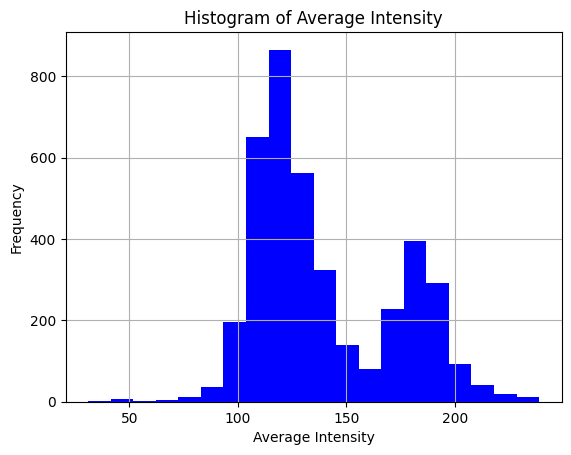

In [92]:
plt.hist(all_sample['intensity'], bins=20, color='blue')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.title('Histogram of Average Intensity')
plt.grid(True)
plt.savefig('avg_intensity_histogram.png')

In [93]:
with open(data_path + 'all_sample.csv', 'w') as f:
    all_sample.to_csv(f, index=False)

### Cropping and resizing images

#### Examining the images and bounding boxes resolution

In [129]:
fix_resolution = [4096, 3328]

In [23]:
def get_sizes_of_ROI(roi_coords_array):
    sizes = []

    for roi in roi_coords_array:
        size_str = f'{roi[2]-roi[0]} x {roi[3] - roi[1]}'
        height = roi[2] - roi[0]
        width = roi[3] - roi[1]
        full_resolution = height * width
        diameter = math.sqrt(height ** 2 + width ** 2)
        sizes.append([size_str,[height, width], height * width, diameter])

    return sizes

def get_size_of_image(image_path):
    image = Image.open(image_path)
    image_array = np.array(image)
    height = image_array.shape[0]
    width = image_array.shape[1]
    full_resolution = height * width
    diameter = math.sqrt( height ** 2 + width ** 2)
    dark_area = np.sum(image_array == 0)
    return [f'{height} x {width}', [height, width], full_resolution, diameter, dark_area]

In [39]:
negative_samples = pd.read_csv(data_path + 'negative_full.csv')
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')

In [45]:
diameters_for_ROI = []
diameters_for_image = []
ratio_of_ROI = []
ratio_of_dark = []

for i in range(len(negative_samples)):
    if i % 10 == 0:
        print(f'{i+1}/{len(negative_samples)}')
    png_image_path = negative_sample.loc[i, 'full_png_path'] 
    image_size = get_size_of_image(png_image_path)
    diameters_for_image.append(image_size[3])

    negative_sample.loc[i, 'image_size_tuple'] = str(image_size)

for i in range(len(calc_findings)):
    if i % 10 == 0:
        print(f'{i + 1}/{len(calc_findings)}')
    roi_coords_str = calc_findings.loc[i,'ROI_coords']
    png_image_path = calc_findings.loc[i, 'full_png_path']
    image_size = get_size_of_image(png_image_path)
    roi_coords = get_sizes_of_ROI(parse_ROI(roi_coords_str))
    
    calc_findings.loc[i, 'image_size_tuple'] = str(image_size)
    calc_findings.loc[i, 'roi_size_tuples'] = str(roi_coords)
    
    for sizes_tuple in roi_coords:
        diameter = sizes_tuple[3]
        diameters_for_ROI.append(diameter)

1/2000
11/2000
21/2000
31/2000
41/2000
51/2000
61/2000
71/2000
81/2000
91/2000
101/2000
111/2000
121/2000
131/2000
141/2000
151/2000
161/2000
171/2000
181/2000
191/2000
201/2000
211/2000
221/2000
231/2000
241/2000
251/2000
261/2000
271/2000
281/2000
291/2000
301/2000
311/2000
321/2000
331/2000
341/2000
351/2000
361/2000
371/2000
381/2000
391/2000
401/2000
411/2000
421/2000
431/2000
441/2000
451/2000
461/2000
471/2000
481/2000
491/2000
501/2000
511/2000
521/2000
531/2000
541/2000
551/2000
561/2000
571/2000
581/2000
591/2000
601/2000
611/2000
621/2000
631/2000
641/2000
651/2000
661/2000
671/2000
681/2000
691/2000
701/2000
711/2000
721/2000
731/2000
741/2000
751/2000
761/2000
771/2000
781/2000
791/2000
801/2000
811/2000
821/2000
831/2000
841/2000
851/2000
861/2000
871/2000
881/2000
891/2000
901/2000
911/2000
921/2000
931/2000
941/2000
951/2000
961/2000
971/2000
981/2000
991/2000
1001/2000
1011/2000
1021/2000
1031/2000
1041/2000
1051/2000
1061/2000
1071/2000
1081/2000
1091/2000
1101/2000
1

NameError: name 'negative' is not defined

In [46]:
all_samples = pd.concat([negative_sample, calc_findings], axis=0)

In [ ]:
plt.hist(diameters_for_ROI)
plt.title('Diameters of bounding rectangles')
plt.savefig('diameters_of_ROI')
plt.show()
plt.hist(diameters_for_image)
plt.title('Diameters of whole image')
plt.savefig('diameters_of_image')
plt.show()

In [172]:
def show_roi_hist(roi_sizes_tuples, image_size_tuples=None):
    ratios_of_ROI = []
    diameters_of_ROI = []
    
    for i, row in enumerate(roi_sizes_tuples):
        if image_size_tuples is not None: 
            image_size_tuple = eval(image_size_tuples[i])
            image_size = image_size_tuple[2]
        else:
            image_size = fix_resolution[0] * fix_resolution[1]
            
        roi_size_tuples = eval(row)
        ratios = []
    
        for roi_tuple in roi_size_tuples:
            ratio = roi_tuple[2] / image_size 
            diameter = roi_tuple[3]
            ratios.append(ratio)
            ratios_of_ROI.append(ratio)
            diameters_of_ROI.append(diameter)
    
        calc_findings.loc[i, 'ratios'] = str(ratios)

    plt.hist(ratios_of_ROI)
    plt.title('Ratios of each ROI bounding rectangle to the whole image')
    plt.savefig('ratio_of_roi')
    plt.show()

    plt.hist(diameters_of_ROI, bins = 30)
    plt.title('Diameters of each bounding rectangle')
    plt.savefig('diameter_of_roi')
    plt.show()

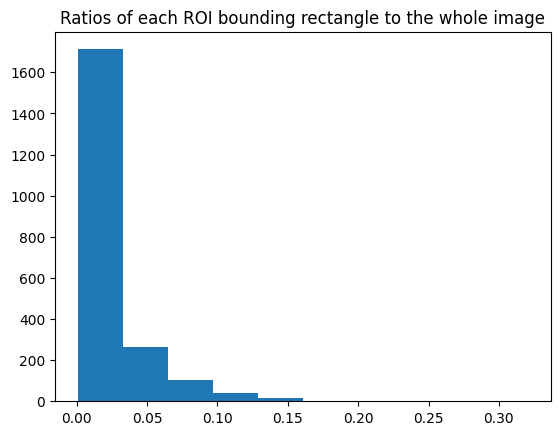

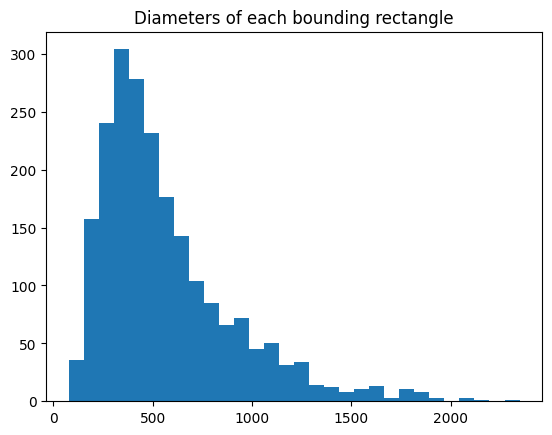

In [173]:
show_roi_hist(calc_findings['roi_size_tuples'], calc_findings['image_size_tuple'])

In [47]:
with open(data_path + 'calc_findings_full.csv', 'w') as f:
    calc_findings.to_csv(f)

with open(data_path + 'negative_full.csv', 'w') as f:
    negative_sample.to_csv(f)

with open(data_path + 'all_sample_full.csv', 'w') as f:
    all_sample.to_csv(f)

In [48]:
from collections import Counter

   Resolution  Frequency
0       1.231       2177
1       1.300       1654
2       1.199         98
3       1.279         26
4       1.339          4
5       1.190          1


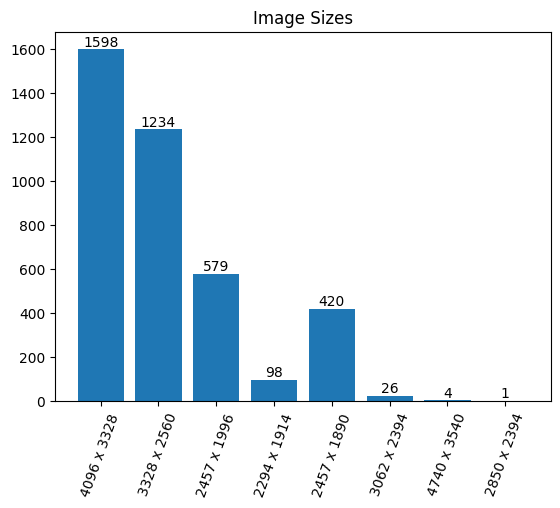

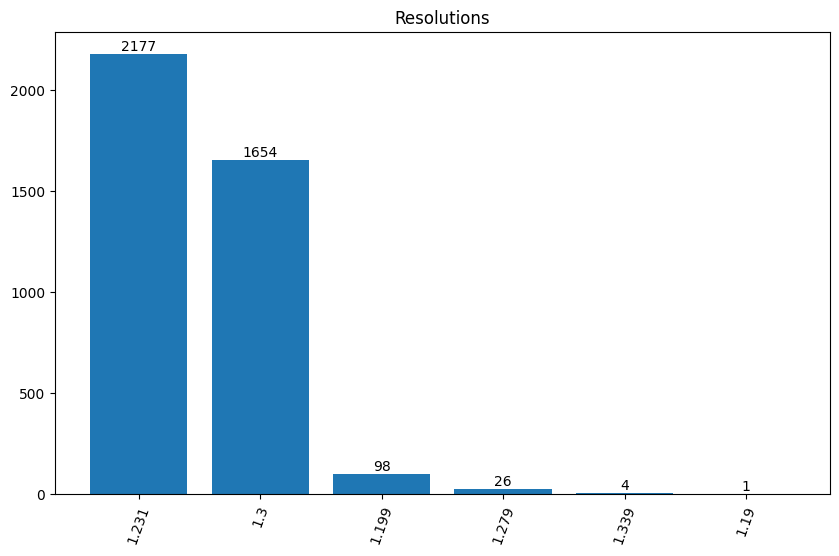

In [49]:
image_sizes_str = [ eval(tuple)[0] for tuple in all_sample['image_size_tuple'] ]
sizes_counted = Counter(image_sizes_str)
sizes = pd.Series(sizes_counted).reset_index()
sizes.columns = ['Image Size', 'Frequency']

resolutions = pd.Series(Counter([ round(eval(tuple)[1][0] / eval(tuple)[1][1], 3) for tuple in all_samples['image_size_tuple'] ])).reset_index()
resolutions.columns = ['Resolution', 'Frequency']
# print(resolutions)
# sizes = sizes.merge(resolutions_counted, on='Frequency')

plt.bar(sizes['Image Size'], sizes['Frequency'])
for i, size in sizes.iterrows():
    plt.text(i, size['Frequency'] + 1, str(size['Frequency']), ha='center', va='bottom')
plt.title('Image Sizes')
plt.xticks(rotation=70)
plt.savefig('sizes')
plt.show()

plt.figure(figsize=(10,6))
plt.bar([str(res) for res in resolutions['Resolution']], resolutions['Frequency'])
for i, resolution in resolutions.iterrows():
    plt.text(i, resolution['Frequency'] + 1, str(resolution['Frequency'].astype(int)), ha='center', va='bottom')
plt.title('Resolutions')
plt.xticks(rotation=70)
plt.savefig('resolutions')
plt.show()

#### Resizing picures to fix size

In [30]:
def resize_calc(i):
    image_path = image_resized_path + f'/{i}_pos.png'
    
    if not Path(image_path).exists():
        df_row = calc_findings.loc[i]
        png_path = df_row['full_png_path']
        size_tuple = eval(df_row['image_size_tuple'])
        original_size = size_tuple[1]
        width_distortion = float(fix_resolution[0]) / float(original_size[0])
        height_distortion = float(fix_resolution[1]) / float(original_size[1])
        
        roi_coords = parse_ROI(df_row['ROI_coords'])
        resized_roi_coords = []
    
        for j, roi_coords in enumerate(roi_coords):
            new_x_min = round(float(roi_coords[0]) * width_distortion)
            new_x_max = round(float(roi_coords[2]) * width_distortion)
            new_y_min = round(float(roi_coords[1]) * height_distortion)
            new_y_max = round(float(roi_coords[3]) * height_distortion)
    
            resized_roi_coords.append([new_x_min, new_y_min, new_x_max, new_y_max])
    
        image = Image.open(png_path)
        resized_image = image.resize(fix_resolution)
        resized_image.save(image_path, 'PNG')
    
        calc_findings.loc[i,'resized_roi_coords'] = str(resized_roi_coords)
        calc_findings.loc[i,'resized_roi_sizes'] = str(get_sizes_of_ROI(resized_roi_coords))
        calc_findings.loc[i,'resized_path'] = image_path

def resize_negative(i):
    image_path = image_resized_path + f'/{i}_neg.png'
    
    if not Path(image_path).exists():
        df_row = negative_sample.loc[i]
        png_path = df_row['full_png_path']
        size_tuple = eval(df_row['image_size_tuple'])
        original_size = size_tuple[1]
        wheightidth_distortion = float(fix_resolution[0]) / float(original_size[0])
        width_distortion = float(fix_resolution[1]) / float(original_size[1])
    
        image = Image.open(png_path)
        resized_image = image.resize(fix_resolution)
        resized_image.save(image_path, 'PNG')
        
        negative_sample.loc[i,'resized_path'] = image_path    

In [31]:
calc_length = len(calc_findings)
negative_length = len(negative_samples)

for i in range(calc_length):
    if i % 10 == 0:
        print(f'Resizing progression for calc_findings {i+1} / {calc_length}')
        
    resize_calc(i)

for i in range(negative_length):
    if i % 10 == 0:
        print(f'Resizing progression for negative pictures {i+1} / {negative_length}')
        
    resize_negative(i)

NameError: name 'negative_samples' is not defined

In [115]:
all_samples = pd.concat([negative_sample, calc_findings], axis=0)

with open(data_path + 'calc_findings_full.csv', 'w') as f:
    calc_findings.to_csv(f)

with open(data_path + 'negative_full.csv', 'w') as f:
    negative_sample.to_csv(f)

with open(data_path + 'all_sample_full.csv', 'w') as f:
    all_sample.to_csv(f)

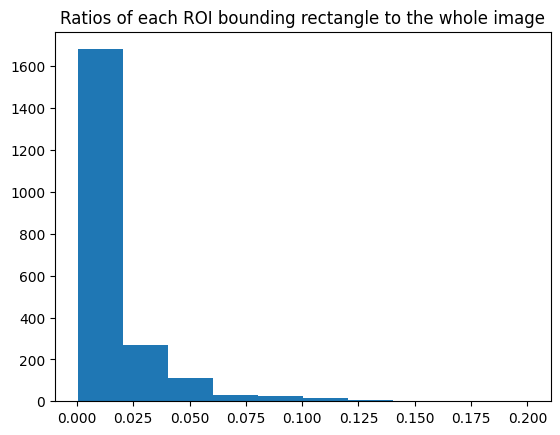

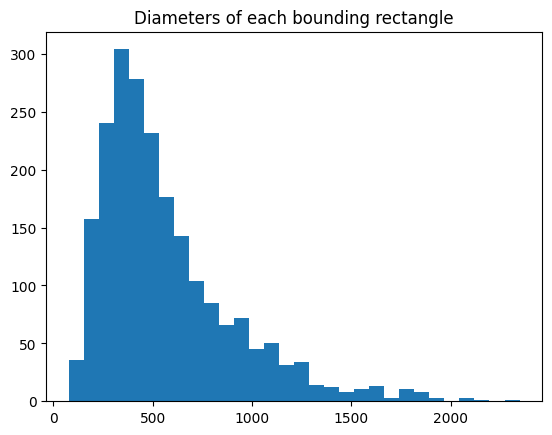

In [174]:
show_roi_hist(calc_findings['roi_size_tuples'])

#### Cropping random images for the final dataset

In [3]:
final_dataframe = pd.DataFrame()
calc_findings = pd.read_csv(data_path + 'calc_findings_full.csv')
negative = pd.read_csv(data_path + 'negative_full.csv')

In [219]:
def crop_positive_image(i):
    calc_finding_row = calc_findings.loc[i]
    image_array = np.array(Image.open(calc_finding_row['resized_path']))
    roi_coords = eval(calc_finding_row['resized_roi_coords'])

    for i, roi_coord in enumerate(roi_coords):
        x_min = roi_coord[0]
        y_min = roi_coord[1]
        x_max = roi_coord[2]
        y_max = roi_coord[3]
        
        roi_array = image_array[y_min:y_max,x_min:x_max]
        plt.axis('off')
        plt.imshow(roi_array, cmap='gray')
        plt.show()

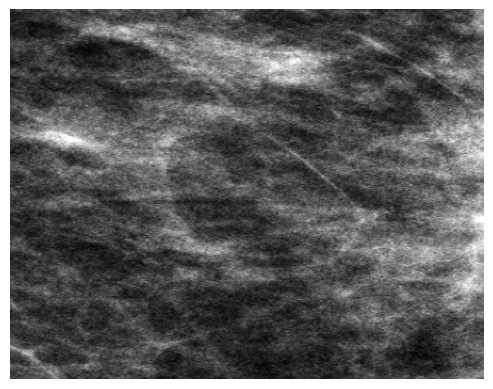

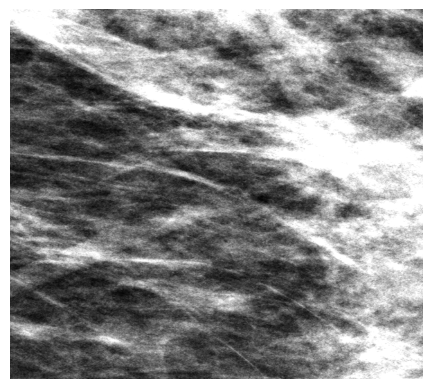

In [222]:
crop_positive_image(31)

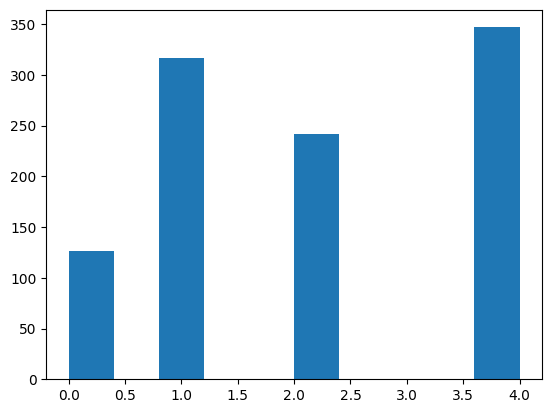

In [290]:
with_path_sev = calc_findings[calc_findings['path_severity'].notna()]
plt.hist(with_path_sev['path_severity'])
plt.show()

In [4]:
data = pd.read_csv(tables_path + 'EMBED_OpenData_clinical.csv')
metadata = pd.read_csv(tables_path + 'EMBED_OpenData_metadata_reduced.csv').rename(columns={'ImageLateralityFinal': 'side'})

pathsevs = data[data['path_severity'].notna()]
rois = metadata[metadata['ROI_coords'].notna()]
all_roi = pathsevs.merge(rois, on=['empi_anon', 'acc_anon','side'])

/tmp/ipykernel_6161/2776892932.py:1: DtypeWarning: Columns (28,31,33,48,49,53,54,55,56,57,59,81,84,85,93,111) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(tables_path + 'EMBED_OpenData_clinical.csv')
/tmp/ipykernel_6161/2776892932.py:2: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(tables_path + 'EMBED_OpenData_metadata_reduced.csv').rename(columns={'ImageLateralityFinal': 'side'})


In [ ]:
print(all_roi[all_roi['calcfind'].notna()] & all_roi['spot_mag'] == 0)